## Ring-hydroxylating Dioxygenases

In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import re
from prince import CA, MCA
import matplotlib.cm as cm
from Bio.SeqUtils import seq3
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pyclustering.cluster.optics import optics
from pyclustering.cluster.optics import ordering_analyser
import networkx as nx

# Download necessary resources from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/lucas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lucas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/lucas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
headers, sequences = [], []
for record in SeqIO.parse('alignment.fasta', "fasta").records:
    headers.append(record.id)
    sequences.append(record.seq)
raw = np.array(sequences)
print(raw.shape)

(9381, 1225)


In [3]:
# Create a data frame from array containing raw data and then clean it up

df = pd.DataFrame(raw)

df.replace(
    ['-', *[chr(i) for i in range(ord('a'), ord('z')+1)]],
    np.nan,
    inplace=True
)

threshold = .9
min_rows = int(threshold * df.shape[0])

# Remove columns with NaN values above the threshold
df.dropna(thresh=min_rows, axis=1, inplace=True)
min_cols = int(threshold * df.shape[1])

print(min_rows, min_cols)

# Remove rows with NaN values above the threshold
df.dropna(thresh=min_cols, axis=0, inplace=True)

row_idx, col_idx = df.index, df.columns

print(df.info)

8442 36
<bound method DataFrame.info of      182 185 186 187 200 204 205 206 216 217  ... 838 841 845 848 851 853 982   
0      A   L   Y   C   E   G   F   H   V   H  ...   T   Y   V   Y   D   E   E  \
1      K   L   Y   M   D   P   Y   H   L   H  ...   Y   F   G   Y   E   D   D   
2      K   L   T   Y   E   N   Y   H   I   H  ...   L   Y   W   K   G   E   E   
3      K   V   F   C   D   G   Y   H   A   H  ...   Y   F   L   E   G   S   E   
4      K   V   V   N   E   C   Y   H   N   H  ...   W   F   V   A   D   A   Q   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
9373   K   T   F   I   E   D   Y   H   F   H  ...   F   F   Y   P   E   E   E   
9376   K   M   Y   L   D   T   V   H   T   H  ...   S   F   R   A   A   G   D   
9377   K   L   T   M   E   C   Y   H   N   H  ...   W   L   V   H   R   D   Q   
9378   K   L   V   V   D   F   Y   H   V   H  ...   V   F   V   D   N   S   Q   
9380   K   L   T   M   E   C   Y   H   N   H  ...   W   C   V   H   R

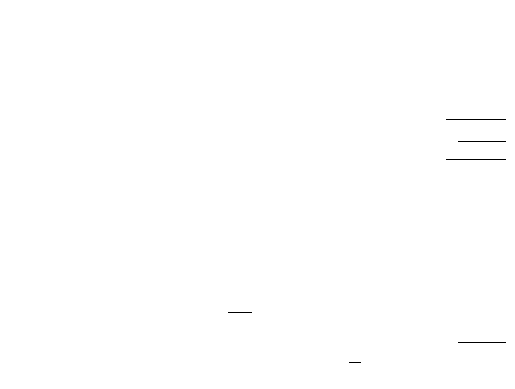

In [4]:
# Plot the heatmap
sns.heatmap(df.isna().astype(int), cmap='binary', xticklabels=False, yticklabels=False, cbar=False)

# Show the plot
plt.show()

In [5]:
# Join the dataframes based on the 'ID' column
if len(df.columns) == len(col_idx):
    if (df.columns == col_idx).all():
        df = pd.merge(
            pd.merge(
                pd.read_csv('data.tsv', delimiter='\t'),
                pd.DataFrame(
                    {
                        'Entry':[headers[idx].split('/')[0].split('_')[0] for idx in df.index],
                        'Index':list(df.index)
                    }
                ),
                on='Entry'
            ),
            df,
            left_on='Index',
            right_index=True,
            how='inner'
        ).copy()
print(df.info)

<bound method DataFrame.info of            Entry        Entry Name   
0     A0A401KD97  A0A401KD97_ASPAW  \
1     A0A024HID4  A0A024HID4_PSEKB   
2     A0A0B7G8U8  A0A0B7G8U8_KLEVA   
3     A0A0D1ZK14  A0A0D1ZK14_9EURO   
4     A0A0F3KB91  A0A0F3KB91_9NEIS   
...          ...               ...   
7221      X8BD72      X8BD72_MYCAV   
7222      X8C3G7      X8C3G7_MYCXE   
7223      X8C7K7      X8C7K7_MYCXE   
7224      X8F6Q2      X8F6Q2_MYCUL   
7225      Y0KGF3      Y0KGF3_9PROT   

                                          Protein names   
0     Bifunctional lycopene cyclase/phytoene synthas...  \
1     Carnitine monooxygenase oxygenase subunit (EC ...   
2     Carnitine monooxygenase oxygenase subunit (EC ...   
3     Choline monooxygenase, chloroplastic (EC 1.14....   
4     Carnitine monooxygenase oxygenase subunit (EC ...   
...                                                 ...   
7221                              Rieske domain protein   
7222                              Riesk

In [6]:
df['Protein names'].value_counts(normalize=True)

Protein names
Aromatic ring-hydroxylating dioxygenase subunit alpha                                                                                0.123997
(2Fe-2S)-binding protein                                                                                                             0.089676
Choline monooxygenase, chloroplastic (EC 1.14.15.7)                                                                                  0.069056
Rieske (2Fe-2S) protein                                                                                                              0.061998
Rieske domain-containing protein                                                                                                     0.059369
                                                                                                                                       ...   
Putative Choline monooxygenase (EC 1.14.15.7)                                                                                        0

In [7]:
# Extract the substrate and enzyme names using regular expressions
matches = df['Protein names'].str.extract(r'(.+?) ([\w\-,]+ase)', flags=re.IGNORECASE)

# String normalization pipeline
df['Substrate'] = matches[0]\
    .fillna('')\
    .apply(lambda x: '/'.join(re.findall(r'\b(\w+(?:ene|ine|ate|yl))\b', x, flags=re.IGNORECASE)))\
    .apply(lambda x: x.lower())

df['Enzyme'] = matches[1]\
    .fillna('')\
    .apply(lambda x: x.split('-')[-1] if '-' in x else x) \
    .apply(lambda x: x.lower())

df = df.copy()

df[['Substrate', 'Enzyme']].value_counts(normalize=True)

Substrate                               Enzyme        
                                                          0.467063
                                        dioxygenase       0.185580
choline                                 monooxygenase     0.090922
phenylpropionate                        dioxygenase       0.072654
benzoate                                dioxygenase       0.043316
anthranilate                            dioxygenase       0.027539
salicylate                              hydroxylase       0.017437
                                        oxygenase         0.015361
biphenyl                                dioxygenase       0.010379
benzene                                 dioxygenase       0.008165
naphthalene                             dioxygenase       0.007750
carnitine                               monooxygenase     0.007750
cumate                                  dioxygenase       0.006643
halobenzoate                            dioxygenase       0.006228
benzoat

In [8]:
df['Enzyme'].value_counts(normalize=True)

Enzyme
                  0.467063
dioxygenase       0.389842
monooxygenase     0.100055
hydroxylase       0.017991
oxygenase         0.015776
demethylase       0.003045
oxidoreductase    0.001384
reductase         0.001384
cyclase           0.000830
synthase          0.000692
diooxygenase      0.000415
decarboxylase     0.000415
dyoxygenase       0.000415
ligase            0.000138
dehydrogenase     0.000138
helicase          0.000138
protease          0.000138
dioxyenase        0.000138
Name: proportion, dtype: float64

In [9]:
df['Substrate'].value_counts(normalize=True)

Substrate
                                          0.672571
choline                                   0.090922
phenylpropionate                          0.072654
benzoate                                  0.043454
anthranilate                              0.027539
salicylate                                0.017714
biphenyl                                  0.010379
benzene                                   0.008165
naphthalene                               0.007750
carnitine                                 0.007750
cumate                                    0.006643
halobenzoate                              0.006228
benzoate/toluate                          0.005397
terephthalate                             0.003737
phenylpropionate/cinnamate                0.003183
glycine/betaine                           0.003045
phthalate                                 0.002629
toluate                                   0.001384
methanesulfonate                          0.001384
phenoxybenzoate      

In [10]:
df['Label'] = df['Substrate'].str.cat(df['Enzyme'], sep=' ').str.strip()
df = df.copy()
df['Label'].value_counts(normalize=True)

Label
                                                        0.467063
dioxygenase                                             0.185580
choline monooxygenase                                   0.090922
phenylpropionate dioxygenase                            0.072654
benzoate dioxygenase                                    0.043316
anthranilate dioxygenase                                0.027539
salicylate hydroxylase                                  0.017437
oxygenase                                               0.015361
biphenyl dioxygenase                                    0.010379
benzene dioxygenase                                     0.008165
carnitine monooxygenase                                 0.007750
naphthalene dioxygenase                                 0.007750
cumate dioxygenase                                      0.006643
halobenzoate dioxygenase                                0.006228
benzoate/toluate dioxygenase                            0.005397
terephthalate dioxy

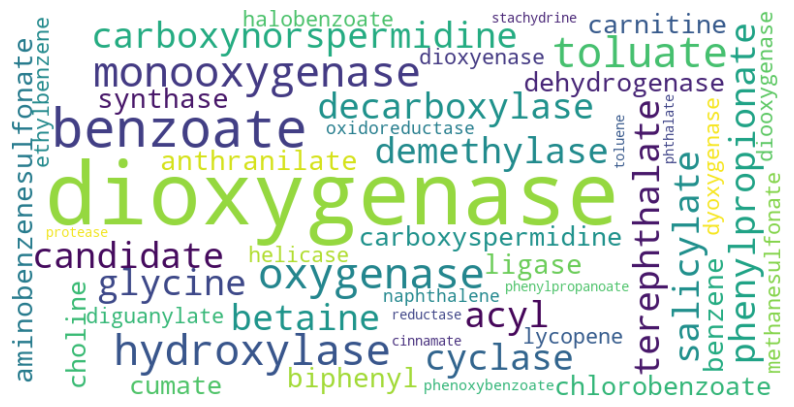

In [11]:
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(
    WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate(
        ' '.join(
            sorted(
                set([string for string in df.Label.values.tolist() if len(string) > 0])
            )
        )
    ),
    interpolation='bilinear'
)
plt.axis('off')
plt.show()

In [12]:
data = df[col_idx].drop_duplicates().fillna('-').copy()
data.info

<bound method DataFrame.info of      182 185 186 187 200 204 205 206 216 217  ... 838 841 845 848 851 853 982   
0      K   L   L   I   E   C   Y   H   S   H  ...   V   Y   R   H   R   D   E  \
1      K   S   I   V   E   C   Y   H   A   H  ...   I   Y   F   L   N   K   E   
2      K   N   I   V   E   C   Y   H   A   H  ...   I   Y   F   T   N   E   E   
3      K   T   L   A   E   C   Y   H   A   H  ...   V   Y   R   H   V   D   E   
4      K   I   I   V   E   C   Y   H   A   H  ...   I   Y   F   R   N   K   E   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
7218   K   M   V   V   D   G   Y   H   T   H  ...   A   V   L   I   P   G   D   
7221   K   L   Y   M   E   F   Y   H   L   H  ...   L   Y   F   P   A   P   Q   
7223   K   M   V   V   D   G   Y   H   T   H  ...   A   V   L   M   P   G   D   
7224   K   V   L   V   E   G   Y   H   T   H  ...   S   M   V   T   P   M   -   
7225   K   T   F   I   E   D   Y   H   F   H  ...   F   Y   Y   P   E   D   E

In [13]:
# Perform MCA
mca = MCA()
mca.fit(data)

# Access the results
coordinates = mca.transform(data)

# mca.plot(
#     data,
#     x_component=0,
#     y_component=1
# )

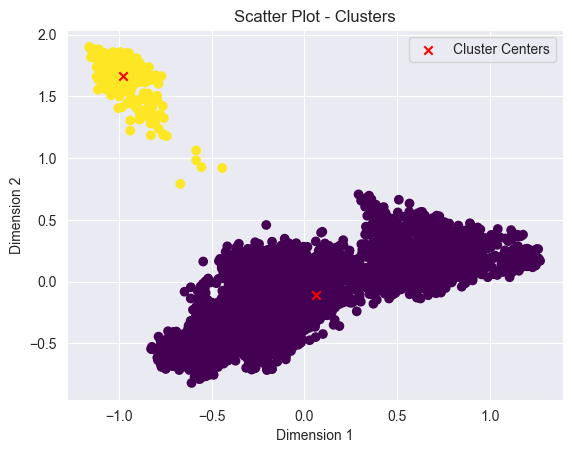

In [14]:
# Assuming 'coordinates' is the result of MCA

# Convert the coordinates to a NumPy array
coordinates = np.array(coordinates)

# Define a range of potential number of clusters to evaluate
min_clusters = 2
max_clusters = 10

# Perform clustering for different number of clusters and compute silhouette scores
silhouette_scores = []
for k in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, n_init=10)  # Set n_init explicitly
    kmeans.fit(coordinates)
    labels = kmeans.labels_
    score = silhouette_score(coordinates, labels)
    silhouette_scores.append(score)

# Find the best number of clusters based on the highest silhouette score
kmeans_best_num_clusters = np.argmax(silhouette_scores) + min_clusters

# Perform clustering with the best number of clusters
kmeans = KMeans(n_clusters=kmeans_best_num_clusters, n_init=10)  # Set n_init explicitly
kmeans.fit(coordinates)
kmeans_cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# Plot the scatter plot colored by clusters
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=kmeans_cluster_labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', label='Cluster Centers')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter Plot - Clusters')
plt.legend()
plt.show()

In [15]:
X = data
y = pd.get_dummies(kmeans_cluster_labels).astype(int) if len(
    set(kmeans_cluster_labels)
) > 2 else kmeans_cluster_labels

# Perform one-hot encoding on the categorical features
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X)

# Get the column names for the encoded features
encoded_feature_names = []
for i, column in enumerate(X.columns):
    categories = encoder.categories_[i]
    for category in categories:
        feature_name = f'{column}_{category}'
        encoded_feature_names.append(feature_name)

# Convert X_encoded to DataFrame
X_encoded_df = pd.DataFrame.sparse.from_spmatrix(X_encoded, columns=encoded_feature_names)

# Create and train the Random Forest classifier
rf = RandomForestClassifier()
rf.fit(X_encoded_df, y)

# Feature selection
feature_selector = SelectFromModel(rf, threshold='.5*median')
X_selected = feature_selector.fit_transform(X_encoded_df, y)

selected_feature_indices = feature_selector.get_support(indices=True)
selected_features = X_encoded_df.columns[selected_feature_indices]

selected_features

Index(['182_-', '182_A', '182_F', '182_G', '182_H', '182_K', '182_L', '182_M',
       '182_N', '182_P',
       ...
       '987_M', '987_N', '987_P', '987_Q', '987_R', '987_S', '987_T', '987_V',
       '987_W', '987_Y'],
      dtype='object', length=728)

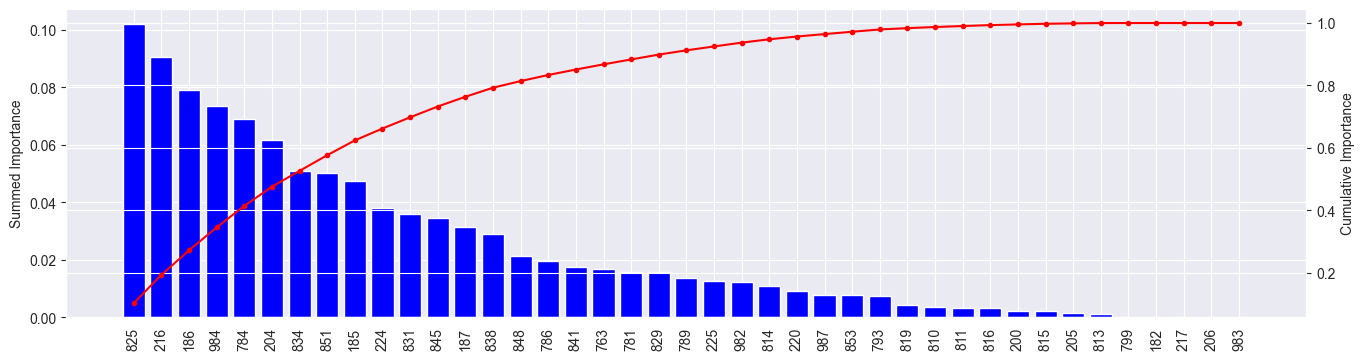

In [16]:
# Calculate feature importances for original columns
sorted_importance = pd.DataFrame(
    {
        'Residues': selected_features,
        'Importance': rf.feature_importances_[selected_feature_indices],
        'Columns': map(lambda x: int(x.split('_')[0]), selected_features)
    }
)[['Columns', 'Importance']].groupby('Columns').sum()['Importance'].sort_values(ascending=False)
sorted_features = sorted_importance.index

fig, ax1 = plt.subplots(figsize=(16, 4))

# Bar chart of percentage importance
xvalues = range(len(sorted_features))
ax1.bar(xvalues, sorted_importance, color='b')
ax1.set_ylabel('Summed Importance')
ax1.tick_params(axis='y')

# Line chart of cumulative percentage importance
ax2 = ax1.twinx()
ax2.plot(xvalues, np.cumsum(sorted_importance) / np.sum(sorted_importance), color='r', marker='.')
ax2.set_ylabel('Cumulative Importance')
ax2.tick_params(axis='y')

# Rotate x-axis labels
plt.xticks(xvalues, sorted_features)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

plt.show()


In [17]:
def henikoff(data):
    data_array = data.to_numpy()  # Convert DataFrame to NumPy array
    size, length = data_array.shape
    weights = []
    for seq_index in range(size):
        row = data_array[seq_index, :]
        unique_vals, counts = np.unique(row, return_counts=True)
        k = len(unique_vals)
        matrix_row = 1. / (k * counts)
        weights.append(np.sum(matrix_row) / length)
    return pd.Series(weights, index=data.index)

In [18]:
weights = henikoff(data[sorted_importance.index])
print(weights)

0       0.013439
1       0.012673
2       0.014160
3       0.009727
4       0.012793
          ...   
7218    0.015018
7221    0.014275
7223    0.015099
7224    0.013326
7225    0.011165
Length: 6219, dtype: float64


In [19]:
df_res = mca.column_coordinates(data[sorted_importance.index]).loc[selected_features]
df_res.info

<bound method DataFrame.info of               0         1
182_-  0.898179  0.333903
182_A  0.162993  0.246427
182_F -0.557214 -0.234802
182_G  0.351427  0.139084
182_H -0.179463 -0.087357
...         ...       ...
987_S -0.249492 -0.654875
987_T  0.008301 -0.291543
987_V  0.226750 -0.124568
987_W -0.085470 -0.163300
987_Y -0.167816 -0.229060

[728 rows x 2 columns]>

In [20]:
# Create an empty graph
G = nx.Graph()
for idx in df_res.index:
    col, aa = idx.split('_')
    col = int(col)
    rows = data[sorted_importance.index].index[data[sorted_importance.index][col] == aa].tolist()
    # Filter and sum values based on valid indices
    p = weights.iloc[[i for i in rows if i < len(weights)]].sum()
    # Add a node with attributes
    G.add_node(
        f'{seq3(aa)}{col}',
        idx=idx,
        aa=aa,
        col=col,
        coord=(
            df_res.loc[idx,0],
            df_res.loc[idx,1]
        ),
        rows=rows,
        p=p
    )
G.nodes

NodeView(('Xaa182', 'Ala182', 'Phe182', 'Gly182', 'His182', 'Lys182', 'Leu182', 'Met182', 'Asn182', 'Pro182', 'Gln182', 'Arg182', 'Ser182', 'Thr182', 'Xaa185', 'Ala185', 'Cys185', 'Phe185', 'Gly185', 'His185', 'Ile185', 'Lys185', 'Leu185', 'Met185', 'Asn185', 'Pro185', 'Gln185', 'Ser185', 'Thr185', 'Val185', 'Trp185', 'Tyr185', 'Xaa186', 'Ala186', 'Cys186', 'Glu186', 'Phe186', 'Gly186', 'His186', 'Ile186', 'Leu186', 'Met186', 'Asn186', 'Pro186', 'Gln186', 'Arg186', 'Ser186', 'Thr186', 'Val186', 'Trp186', 'Tyr186', 'Xaa187', 'Ala187', 'Cys187', 'Asp187', 'Phe187', 'Gly187', 'His187', 'Ile187', 'Lys187', 'Leu187', 'Met187', 'Asn187', 'Pro187', 'Gln187', 'Arg187', 'Ser187', 'Thr187', 'Val187', 'Trp187', 'Tyr187', 'Ala200', 'Cys200', 'Asp200', 'Glu200', 'Gly200', 'Ile200', 'Leu200', 'Asn200', 'Ser200', 'Thr200', 'Xaa204', 'Ala204', 'Cys204', 'Asp204', 'Glu204', 'Phe204', 'Gly204', 'His204', 'Ile204', 'Leu204', 'Met204', 'Asn204', 'Pro204', 'Gln204', 'Arg204', 'Ser204', 'Thr204', 'Val204', 

In [21]:
for u in G.nodes:
    print(G.nodes[u]['idx'])

182_-
182_A
182_F
182_G
182_H
182_K
182_L
182_M
182_N
182_P
182_Q
182_R
182_S
182_T
185_-
185_A
185_C
185_F
185_G
185_H
185_I
185_K
185_L
185_M
185_N
185_P
185_Q
185_S
185_T
185_V
185_W
185_Y
186_-
186_A
186_C
186_E
186_F
186_G
186_H
186_I
186_L
186_M
186_N
186_P
186_Q
186_R
186_S
186_T
186_V
186_W
186_Y
187_-
187_A
187_C
187_D
187_F
187_G
187_H
187_I
187_K
187_L
187_M
187_N
187_P
187_Q
187_R
187_S
187_T
187_V
187_W
187_Y
200_A
200_C
200_D
200_E
200_G
200_I
200_L
200_N
200_S
200_T
204_-
204_A
204_C
204_D
204_E
204_F
204_G
204_H
204_I
204_L
204_M
204_N
204_P
204_Q
204_R
204_S
204_T
204_V
204_W
204_Y
205_-
205_A
205_C
205_D
205_E
205_F
205_G
205_H
205_I
205_K
205_L
205_M
205_N
205_P
205_Q
205_R
205_S
205_T
205_V
205_W
205_Y
206_-
206_A
206_H
206_P
206_Y
216_A
216_C
216_F
216_G
216_I
216_K
216_L
216_M
216_N
216_P
216_R
216_S
216_T
216_V
216_Y
217_G
217_H
217_R
217_Y
220_A
220_C
220_D
220_E
220_F
220_G
220_H
220_I
220_K
220_L
220_M
220_N
220_P
220_Q
220_R
220_S
220_T
220_V
220_W
220_Y
224_